In [1]:
import xarray as xr

In [2]:
import pandas as pd
import numpy as np

# Review of our format

In [3]:
ds0 = xr.open_dataset("/home/brendan/Documents/inversions/paris_ch4_tests/CH4_EUROPE_PARIS_dec2023_weighted_2021-02-01.nc")

# Concentrations (timeseries) netCDF

## add quantiles for prior predictive

In [4]:
import pymc as pm
import arviz as az

min_model_error = 20.0

with pm.Model(coords={"nmeasure": ds0.nmeasure}) as model:
    x = pm.TruncatedNormal("x", mu=1.0, sigma=1.0, lower=0.0, shape=ds0.dims["nlatent"])
    bc = pm.TruncatedNormal("bc", mu=1.0, sigma=0.1, lower=0.0, shape=ds0.dims["nBC"])
    sigma = pm.Uniform("sigma", lower=0.1, upper=1, shape=(ds0.dims["nsigma_site"], ds0.dims["nsigma_time"]))

    muBC = pm.Deterministic("muBC", pm.math.dot(ds0.bcsensitivity.values, bc), dims="nmeasure")
    mu = pm.Deterministic("mu", pm.math.dot(ds0.xsensitivity.values, x) + muBC, dims="nmeasure")

    mult_error = np.abs(pm.math.dot(ds0.xsensitivity.values, x)) * sigma[ds0.siteindicator.values.astype(int), ds0.sigmafreqindex.values.astype(int)]
    epsilon = pm.math.sqrt(ds0.Yerror.values**2 + mult_error**2 + min_model_error**2)
    ymodbc = pm.Normal("ymodbc", muBC, epsilon, dims="nmeasure")
    ymod = pm.Normal("ymod", mu, epsilon, dims="nmeasure")
    idata = pm.sample_prior_predictive(1000)

Sampling: [bc, sigma, x, ymod, ymodbc]


In [6]:
idata.prior

<xarray.Dataset>
Dimensions:      (chain: 1, draw: 1000, nmeasure: 4074, sigma_dim_0: 30,
                  sigma_dim_1: 1, bc_dim_0: 4, x_dim_0: 499)
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * nmeasure     (nmeasure) int64 0 1 2 3 4 5 ... 4068 4069 4070 4071 4072 4073
  * sigma_dim_0  (sigma_dim_0) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * sigma_dim_1  (sigma_dim_1) int64 0
  * bc_dim_0     (bc_dim_0) int64 0 1 2 3
  * x_dim_0      (x_dim_0) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498
Data variables:
    ymodbc       (chain, draw, nmeasure) float64 1.909e+03 ... 1.857e+03
    mu           (chain, draw, nmeasure) float64 1.907e+03 ... 1.871e+03
    sigma        (chain, draw, sigma_dim_0, sigma_dim_1) float64 0.4894 ... 0...
    ymod         (chain, draw, nmeasure) float64 1.881e+03 ... 1.906e+03
    muBC         (chain, draw, nmeasure) float64 1.895e+03 ... 1.823e+03
    bc           (chain, draw, bc_dim_0) float64 0.8626 1.014 ... 0.8946 0.9271
    x            (chain, draw, x_dim_0) float64 1.763 1.195 ... 1.866 1.062
Attributes:
    created_at:                 2024-01-10T10:36:45.478473
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

In [6]:
probs = (0.025, 0.159, 0.841, 0.975)

In [7]:
y_mod = idata.prior.ymod.isel(chain=0)
y_mod_q = np.quantile(y_mod, probs, axis=0)

qYmod_da = xr.DataArray(y_mod_q, coords=[list(probs), ds0.nmeasure], dims=["nUI", "nmeasure"])
qYmod_da = qYmod_da.rename("qYmod").transpose("nmeasure", "nUI")

In [8]:
y_modbc = idata.prior.ymodbc.isel(chain=0)
y_modbc_q = np.quantile(y_modbc, probs, axis=0)

qYmodBC_da = xr.DataArray(y_modbc_q, coords=[list(probs), ds0.nmeasure], dims=["nUI", "nmeasure"])
qYmodBC_da = qYmodBC_da.rename("qYaprioriBC").transpose("nmeasure", "nUI")

In [9]:
mu = idata.prior.mu.isel(chain=0)
mu_q = np.quantile(mu, probs, axis=0)

qmu_da = xr.DataArray(mu_q, coords=[list(probs), ds0.nmeasure], dims=["nUI", "nmeasure"])
qmu_da = qmu_da.rename("qmu").transpose("nmeasure", "nUI")

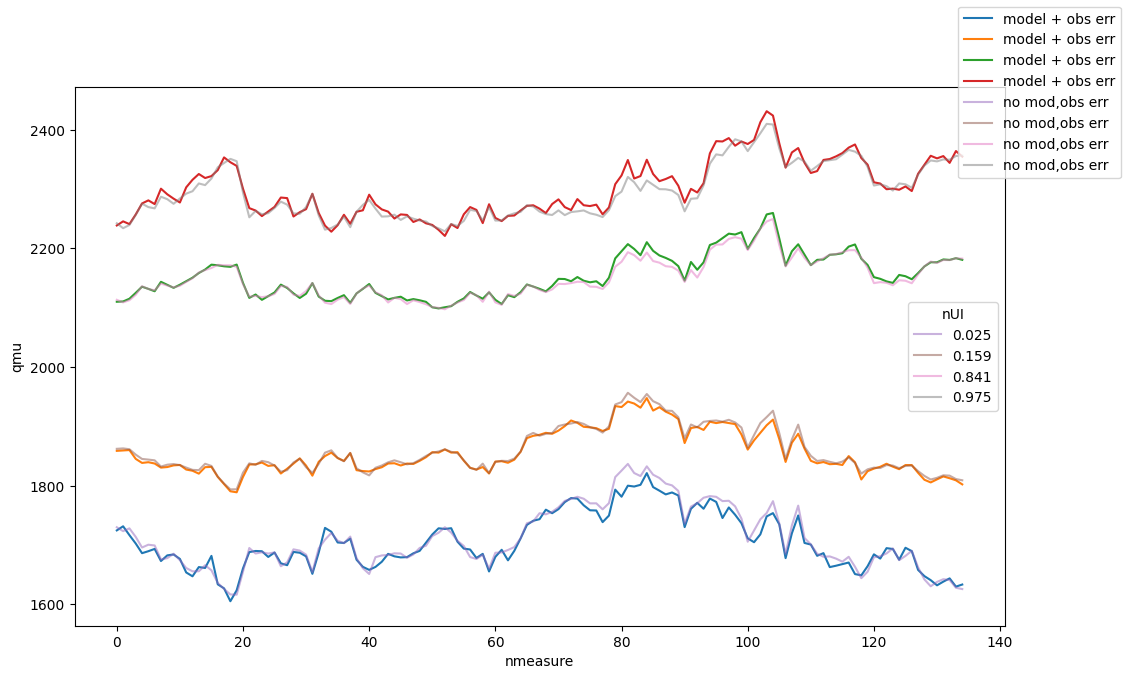

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,7))
qYmod_da.where(ds0.siteindicator == 0, drop=True).plot.line(x="nmeasure", ax=ax, label="model + obs err")
qmu_da.where(ds0.siteindicator == 0, drop=True).plot.line(x="nmeasure", ax=ax, label="no mod,obs err", alpha=0.5)
fig.legend()

## rename coordinates

Coordinate names should match dimension names (in our format... and in general, why not?)

In [11]:
ds0 = ds0.rename_vars(stepnum="steps", paramnum="nlatent", numBC="nBC", measurenum="nmeasure", UInum="nUI")

## make quantiles variable

We need to combine the 68 and 95 confidence intervals into a single variable.

First let's convert `nUI` to the right probabilities

In [12]:
ds68 = ds0[["Ymod68", "Ymod68BC"]].assign_coords(nUI=(ds0.nUI * .682 + 0.159))

In [13]:
ds95 = ds0[["Ymod95", "Ymod95BC"]].assign_coords(nUI=(ds0.nUI * .95 + 0.025))

In [14]:
qYapost_da = xr.concat([ds68.Ymod68, ds95.Ymod95], dim="nUI") 
qYapostBC_da = xr.concat([ds68.Ymod68BC, ds95.Ymod95BC], dim="nUI")

In [15]:
ds0 = ds0.rename_vars(Yerror="uYobs", Ymodmean="Yapost", YmodmeanBC="YapostBC").drop_vars(["Ymod68", "Ymod95", "Ymod68BC", "Ymod95BC"])

In [16]:
ds0 = ds0.drop_dims("nUI")

Now we can add the quantile variables to ds0 and rename vars...

In [17]:
qYapost_da = qYapost_da.rename("qYapost")
qYapostBC_da = qYapostBC_da.rename("qYapostBC")

In [18]:
qyapost = xr.merge([qYapost_da, qYapostBC_da]).reindex_like(qYmod_da)

In [19]:
ds0 = xr.merge([ds0, qYmod_da, qYmodBC_da, qyapost])

### select timeseries data
This only applies for timeseries data, so select those first

In [20]:
time_vars = [dv for dv in ds0.data_vars if "nmeasure" in list(ds0[dv].coords)]

In [21]:
time_vars = [tv for tv in time_vars if "mode" not in tv and "median" not in tv and "off" not in tv and "sensitivity" not in tv and "sigma" not in tv]

In [22]:
ds = ds0[time_vars]  # last two items are sensitivities

##  `nmeasure` to `(time, nsite)`

In [23]:
site_nums = np.arange(ds.siteindicator.max())

In [24]:
ds_unstack = (xr.concat([ds.where(ds.siteindicator == site_num, drop=True)
                        .expand_dims({"nsite": [site_num]})
                        .assign_coords(nmeasure=ds.Ytime.where(ds.siteindicator == site_num, drop=True))
                        .rename_vars(nmeasure="time")
                        for site_num in site_nums], dim="nsite")
              #  .swap_dims(nmeasure="time")
                .drop_vars(["Ytime", "siteindicator"]))

In [ ]:
ds_unstack = ds_unstack.rename_vars(nUI="probs")  #.swap_dims(nmeasure="time", nUI="probs")

## Updating attributes

In [26]:
import json

Attributes for data vars, extracted from netcdf template for concentrations:

```
import json
import re

attr_dict = {}
var_pat = re.compile(r"\s*[a-z]+ ([a-zA-Z]+)\(.*\)")
attr_pat = re.compile(r"\s+([a-zA-Z]+):([a-zA-Z]+)\s*=\s*([^;]+)")

with open("netcdf_template_concentrations_bm_edits.txt", "r") as f:
   in_vars = False
   for line in f.readlines():
       if line.startswith("variables"):
           in_vars = True
       if in_vars:
           if (m := var_pat.match(line)):
               attr_dict[m.group(1)] = {}
           if (m := attr_pat.match(line)):
               attr_dict[m.group(1)][m.group(2)] = m.group(3).strip().strip('"')
               
with open("data_var_attrs.json", "w") as f:
    json.dump(attr_dict, f)
```

In [27]:
with open("data_var_attrs.json", "r") as f:
    data_var_attrs = json.load(f)

In [28]:
data_var_attrs

{'time': {'longname': 'time',
  'units': 'seconds since 1970-01-01 00:00:00',
  'calendar': 'proleptic_gregorian'},
 'probs': {'FillValue': 'NaN', 'units': '-', 'longname': 'probability'},
 'Yobs': {'units': 'mol/mol', 'longname': 'observed_mol_fraction'},
 'uYobs': {'units': 'mol/mol',
  'longname': 'uncertainty_of_observed_mol_fraction'},
 'qYmod': {'units': 'mol/mol',
  'longname': 'quantiles_of_prior_simulated_mol_fraction'},
 'Yapriori': {'units': 'mol/mol',
  'longname': 'apriori_simulated_mole_fraction'},
 'Yapost': {'units': 'mol/mol',
  'longname': 'aposteriori_simulated_mole_fraction'},
 'qYapost': {'units': 'mol/mol',
  'longname': 'quantiles_of_aposteriori_simulated_mole_fraction'},
 'YaprioriBC': {'units': 'mol/mol',
  'longname': 'apriori_simulated_boundary_condition_mole_fraction'},
 'uYaprioriBC': {'units': 'mol/mol',
  'longname': 'uncertainty_of_apriori_simulated_boundary_condition_mole_fraction'},
 'YapostBC': {'units': 'mol/mol',
  'longname': 'aposteriori_simulated

Some attributes will only be correct if we change the units of the values in the data variable:
- `time` needs to be changed to seconds from UNIX epoch
- all `Y` varaibles need to be multiplied by `1e-9` to be in mol/mol instead of ppb

The fill value variables are probably set by `to_netcdf`?

In [29]:
data_var_attrs = {k: {j: w for j, w in v.items() if "FillValue" not in w} for k, v in data_var_attrs.items()}

In [30]:
ds = ds_unstack  # for convenience

In [31]:
ds

<xarray.Dataset>
Dimensions:      (nUI: 4, nmeasure: 168, nsite: 29)
Coordinates:
  * probs        (nUI) float64 0.025 0.159 0.841 0.975
  * time         (nmeasure) datetime64[ns] 2021-02-01 ... 2021-02-28T20:00:00
  * nsite        (nsite) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0
Dimensions without coordinates: nUI, nmeasure
Data variables:
    Yobs         (nsite, nmeasure) float64 1.978e+03 1.977e+03 ... nan nan
    uYobs        (nsite, nmeasure) float64 0.5214 0.06366 0.9982 ... nan nan nan
    Yapriori     (nsite, nmeasure) float64 1.978e+03 1.976e+03 ... nan nan
    Yapost       (nsite, nmeasure) float64 1.992e+03 1.989e+03 ... nan nan
    YaprioriBC   (nsite, nmeasure) float64 1.969e+03 1.969e+03 ... nan nan
    YapostBC     (nsite, nmeasure) float64 1.975e+03 1.974e+03 ... nan nan
    qYmod        (nsite, nmeasure, nUI) float64 1.725e+03 1.859e+03 ... nan nan
    qYaprioriBC  (nsite, nmeasure, nUI) float64 1.723e+03 1.846e+03 ... nan nan
    qYapost      (nsite, nmeasure, nUI) float64 1.986e+03 1.988e+03 ... nan nan
    qYapostBC    (nsite, nmeasure, nUI) float64 1.973e+03 1.974e+03 ... nan nan
Attributes: (12/15)
    Start date:           2021-02-01
    End date:             2021-03-01
    Latent sampler:       mc.nuts.NUTS 
    Hyper sampler:        licer.Slice o
    Burn in:              10000
    Tuning steps:         10000
    ...                   ...
    Model error Prior:    pdf,uniform,lower,0.1,upper,1.0
    BCs Prior:            pdf,truncatednormal,mu,1.0,sigma,0.1,lower,0.0
    Creator:              cv18710
    Date created:         2023-12-12 20:35:08.980406
    Convergence:          Passed
    Repository version:   Unknown

We want uncertainties for YaprioriBC rather than quantiles:

In [32]:
uYaprioriBC_da = (ds.qYaprioriBC.isel(nUI=2) - ds.qYaprioriBC.isel(nUI=1))/2

In [33]:
uYaprioriBC_da

<xarray.DataArray 'qYaprioriBC' (nsite: 29, nmeasure: 168)>
array([[129.20064993, 126.51433823, 129.37438504, ..., 191.91961702,
                 nan, 186.41924908],
       [141.04888353, 144.41735363, 138.34913364, ..., 181.82817538,
        180.05287192, 180.94721492],
       [         nan, 153.31028193, 151.96349861, ..., 185.45725274,
        190.01232009, 196.21219413],
       ...,
       [133.97590886, 136.53679706, 132.27848334, ..., 181.74056343,
        185.12577312, 185.02571561],
       [156.06358604, 150.11884944, 148.10359446, ..., 168.96069479,
        169.15343479, 171.96910534],
       [163.62501751, 178.20726324, 180.75174454, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time     (nmeasure) datetime64[ns] 2021-02-01 ... 2021-02-28T20:00:00
  * nsite    (nsite) float64 0.0 1.0 2.0 3.0 4.0 ... 24.0 25.0 26.0 27.0 28.0
Dimensions without coordinates: nmeasure

In [34]:
ds["uYaprioriBC"] = uYaprioriBC_da
ds = ds.drop_vars("qYaprioriBC")

### Formatting `time` coord

In [35]:
ds = ds.assign_coords(time=(pd.DatetimeIndex(ds.time) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

In [36]:
current_units = 1e-9  # mol/mol
for k, v in data_var_attrs.items():
    if k in ds.data_vars:
        if "units" in v and "mol/mol" in v["units"]:
            ds[k] = current_units * ds[k]
        ds[k].attrs = v
    elif k in ds.coords:
        ds.coords[k].attrs = v

In [37]:
ds

<xarray.Dataset>
Dimensions:      (nUI: 4, nsite: 29, nmeasure: 168, time: 168)
Coordinates:
  * probs        (nUI) float64 0.025 0.159 0.841 0.975
  * nsite        (nsite) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0
  * time         (time) int64 1612137600 1612152000 ... 1614528000 1614542400
Dimensions without coordinates: nUI, nmeasure
Data variables:
    Yobs         (nsite, nmeasure) float64 1.978e-06 1.977e-06 ... nan nan
    uYobs        (nsite, nmeasure) float64 5.214e-10 6.366e-11 ... nan nan
    Yapriori     (nsite, nmeasure) float64 1.978e-06 1.976e-06 ... nan nan
    Yapost       (nsite, nmeasure) float64 1.992e-06 1.989e-06 ... nan nan
    YaprioriBC   (nsite, nmeasure) float64 1.969e-06 1.969e-06 ... nan nan
    YapostBC     (nsite, nmeasure) float64 1.975e-06 1.974e-06 ... nan nan
    qYmod        (nsite, nmeasure, nUI) float64 1.725e-06 1.859e-06 ... nan nan
    qYapost      (nsite, nmeasure, nUI) float64 1.986e-06 1.988e-06 ... nan nan
    qYapostBC    (nsite, nmeasure, nUI) float64 1.973e-06 1.974e-06 ... nan nan
    uYaprioriBC  (nsite, nmeasure) float64 1.292e-07 1.265e-07 ... nan nan
Attributes: (12/15)
    Start date:           2021-02-01
    End date:             2021-03-01
    Latent sampler:       mc.nuts.NUTS 
    Hyper sampler:        licer.Slice o
    Burn in:              10000
    Tuning steps:         10000
    ...                   ...
    Model error Prior:    pdf,uniform,lower,0.1,upper,1.0
    BCs Prior:            pdf,truncatednormal,mu,1.0,sigma,0.1,lower,0.0
    Creator:              cv18710
    Date created:         2023-12-12 20:35:08.980406
    Convergence:          Passed
    Repository version:   Unknown

In [38]:
ds[[k for k in data_var_attrs.keys() if "Y" in k][:-2]]

<xarray.Dataset>
Dimensions:      (nsite: 29, nmeasure: 168, nUI: 4)
Coordinates:
  * probs        (nUI) float64 0.025 0.159 0.841 0.975
  * nsite        (nsite) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0
Dimensions without coordinates: nmeasure, nUI
Data variables:
    Yobs         (nsite, nmeasure) float64 1.978e-06 1.977e-06 ... nan nan
    uYobs        (nsite, nmeasure) float64 5.214e-10 6.366e-11 ... nan nan
    qYmod        (nsite, nmeasure, nUI) float64 1.725e-06 1.859e-06 ... nan nan
    Yapriori     (nsite, nmeasure) float64 1.978e-06 1.976e-06 ... nan nan
    Yapost       (nsite, nmeasure) float64 1.992e-06 1.989e-06 ... nan nan
    qYapost      (nsite, nmeasure, nUI) float64 1.986e-06 1.988e-06 ... nan nan
    YaprioriBC   (nsite, nmeasure) float64 1.969e-06 1.969e-06 ... nan nan
    uYaprioriBC  (nsite, nmeasure) float64 1.292e-07 1.265e-07 ... nan nan
    YapostBC     (nsite, nmeasure) float64 1.975e-06 1.974e-06 ... nan nan
    qYapostBC    (nsite, nmeasure, nUI) float64 1.973e-06 1.974e-06 ... nan nan
Attributes: (12/15)
    Start date:           2021-02-01
    End date:             2021-03-01
    Latent sampler:       mc.nuts.NUTS 
    Hyper sampler:        licer.Slice o
    Burn in:              10000
    Tuning steps:         10000
    ...                   ...
    Model error Prior:    pdf,uniform,lower,0.1,upper,1.0
    BCs Prior:            pdf,truncatednormal,mu,1.0,sigma,0.1,lower,0.0
    Creator:              cv18710
    Date created:         2023-12-12 20:35:08.980406
    Convergence:          Passed
    Repository version:   Unknown

In [39]:
ds

<xarray.Dataset>
Dimensions:      (nUI: 4, nsite: 29, nmeasure: 168, time: 168)
Coordinates:
  * probs        (nUI) float64 0.025 0.159 0.841 0.975
  * nsite        (nsite) float64 0.0 1.0 2.0 3.0 4.0 ... 25.0 26.0 27.0 28.0
  * time         (time) int64 1612137600 1612152000 ... 1614528000 1614542400
Dimensions without coordinates: nUI, nmeasure
Data variables:
    Yobs         (nsite, nmeasure) float64 1.978e-06 1.977e-06 ... nan nan
    uYobs        (nsite, nmeasure) float64 5.214e-10 6.366e-11 ... nan nan
    Yapriori     (nsite, nmeasure) float64 1.978e-06 1.976e-06 ... nan nan
    Yapost       (nsite, nmeasure) float64 1.992e-06 1.989e-06 ... nan nan
    YaprioriBC   (nsite, nmeasure) float64 1.969e-06 1.969e-06 ... nan nan
    YapostBC     (nsite, nmeasure) float64 1.975e-06 1.974e-06 ... nan nan
    qYmod        (nsite, nmeasure, nUI) float64 1.725e-06 1.859e-06 ... nan nan
    qYapost      (nsite, nmeasure, nUI) float64 1.986e-06 1.988e-06 ... nan nan
    qYapostBC    (nsite, nmeasure, nUI) float64 1.973e-06 1.974e-06 ... nan nan
    uYaprioriBC  (nsite, nmeasure) float64 1.292e-07 1.265e-07 ... nan nan
Attributes: (12/15)
    Start date:           2021-02-01
    End date:             2021-03-01
    Latent sampler:       mc.nuts.NUTS 
    Hyper sampler:        licer.Slice o
    Burn in:              10000
    Tuning steps:         10000
    ...                   ...
    Model error Prior:    pdf,uniform,lower,0.1,upper,1.0
    BCs Prior:            pdf,truncatednormal,mu,1.0,sigma,0.1,lower,0.0
    Creator:              cv18710
    Date created:         2023-12-12 20:35:08.980406
    Convergence:          Passed
    Repository version:   Unknown